# **A Multi-Modal Deep Learning Framework for Crop Price Prediction on Crop Price Prediction Dataset**

## 🔁 Hybrid Architecture Flowchart
```mermaid
graph TD
    A[Raw Crop Data] --> B[Preprocessing & Encoding]
    B --> C[Feature Engineering (Lags, Rolling)]
    C --> D1[BiLSTM Model]
    C --> D2[XGBoost Regressor]
    D1 --> E1[LSTM Predictions]
    D2 --> E2[Residuals Predictions]
    E1 --> F[Hybrid Output = LSTM + XGBoost]
    E2 --> F
    F --> G[Performance Evaluation & SHAP Explainability]
```


In [1]:
# ✅ Fix NumPy compatibility issue
!pip uninstall -y numpy
!pip install numpy==1.26.4 --force-reinstall --no-cache-dir


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 279.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# 🔄 Restart the runtime to apply changes (automatically)
import os
os.kill(os.getpid(), 9)

In [1]:
# !pip install -q pycaret shap category_encoders pandas-profiling xgboost tensorflow kagglehub
!pip install -q pycaret shap category_encoders xgboost kagglehub
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 135.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json here
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d santoshd3/crop-price-prediction
!unzip crop-price-prediction.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/santoshd3/crop-price-prediction
License(s): other
  0% 0.00/168k [00:00<?, ?B/s]
100% 168k/168k [00:00<00:00, 560MB/s]
Archive:  crop-price-prediction.zip
  inflating: corn yield.csv          
  inflating: dataset_42_soybean.csv  


In [11]:
import pandas as pd

# List contents to verify exact filename
import os
print(os.listdir())

# Then load
df = pd.read_csv("corn yield.csv")
df.head()

cols_to_remove = ["Program","Week Ending","Ag District","Ag District Code","County","County ANSI",
                  "Zip Code","Region","Watershed","CV (%)","Domain Category","Commodity",
                  "Geo Level","watershed_code","Domain"]
df.drop(columns=cols_to_remove, inplace=True)
df["State ANSI"].fillna(0, inplace=True)
df["Value"] = df["Value"].str.replace(',', '')
df["State ANSI"] = df["State ANSI"].astype(int)
df["Value"] = df["Value"].astype(float)

# Remove outliers
from scipy.stats import zscore
df["z_score"] = zscore(df["Value"])
df = df[df["z_score"].abs() < 3]
df.drop(columns=["z_score"], inplace=True)

['.config', 'dataset_42_soybean.csv', 'crop-price-prediction.zip', 'corn yield.csv', 'kaggle.json', 'sample_data']


In [12]:
cat_features = df.select_dtypes(include=['object']).columns
encoder = ce.OneHotEncoder(cols=cat_features, use_cat_names=True)
df_encoded = encoder.fit_transform(df)

df_encoded['lag_1'] = df_encoded['Value'].shift(1)
df_encoded['lag_7'] = df_encoded['Value'].shift(7)
df_encoded['lag_30'] = df_encoded['Value'].shift(30)
df_encoded['roll_mean_7'] = df_encoded['Value'].rolling(7).mean()
df_encoded['roll_std_7'] = df_encoded['Value'].rolling(7).std()
df_encoded.dropna(inplace=True)

In [13]:
# Full scaling
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)

In [14]:
X = df_scaled.drop("Value", axis=1)
y = df_scaled["Value"]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [15]:
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))



In [18]:
model = Sequential()
model.add(Bidirectional(LSTM(32), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='log_cosh')


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


462/462 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 2/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0023 - val_loss: 9.3251e-04
Epoch 3/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0014 - val_loss: 9.1713e-04
Epoch 4/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011 - val_loss: 9.9586e-04
Epoch 5/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.8515e-04 - val_loss: 8.1529e-04
Epoch 6/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.8946e-04 - val_loss: 7.3073e-04
Epoch 7/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.2302e-04 - val_loss: 6.6901e-04
Epoch 8/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.1251e-04 - val_loss: 6.5036e-04
Epoch 9/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.7393e-04 - val_loss: 6.1279e-04
Epoch 10/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.2577e-04 - val_loss: 6.2240e-04
Epoch 11/100
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.9904e-04 - val_lo

In [19]:
lstm_train_preds = model.predict(X_train_lstm).flatten()
lstm_test_preds = model.predict(X_test_lstm).flatten()

residual_train = y_train.values - lstm_train_preds
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, residual_train)
xgb_residuals = xgb_model.predict(X_test)
hybrid_preds = lstm_test_preds + xgb_residuals

rmse = np.sqrt(mean_squared_error(y_test, hybrid_preds))
mae = mean_absolute_error(y_test, hybrid_preds)
r2 = r2_score(y_test, hybrid_preds)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)


577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 0.07178790390305441
MAE: 0.02628534090563159
R2: 0.5453415393937249


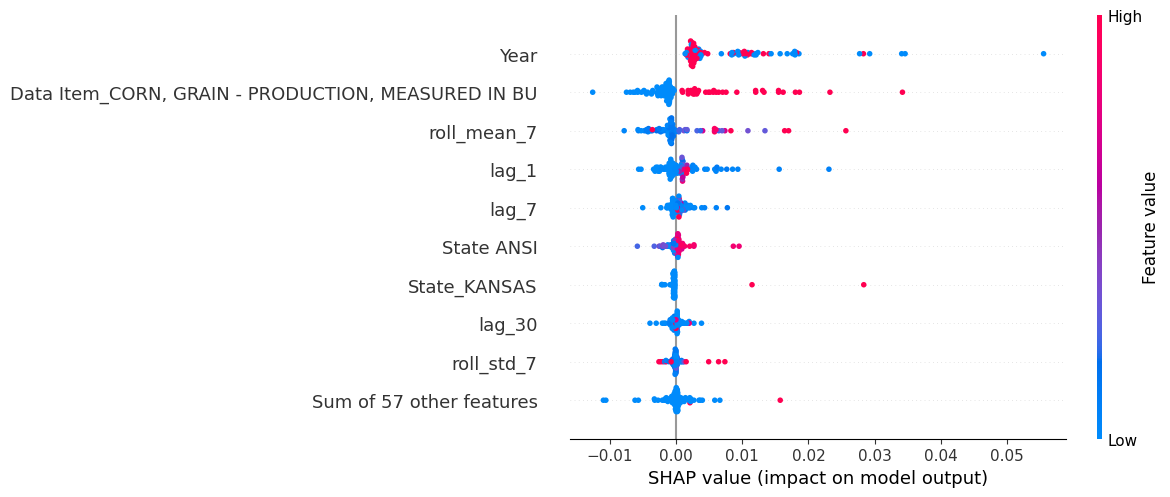

In [20]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test[:100])
shap.plots.beeswarm(shap_values)

Thank You